## Project TODO Steps
 1. create dataset
  - create single signal generator class
  - create mixed signal generator class
  - create noise functions (Gaussian, OU, etc.)
 2. create network
 3. train network
 4. test network

## Parameters to test
 1. sequence length
 2. amplitude
 3. frequency (period)
 4. offset
 5. phase
 6. noise
 
## Questions to answer
 1. What would a batch look like?
 2. How many LSTM layers do we need? nodes per LSTM layer?
 3. Can we learn if our timestamps are not uniformly spaced.

In [1]:
import numpy as np
import pandas as pd
from random import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

## Build a signal generator

In [4]:
from discrimnn.signal import MixedSignal

(1201, 1, 1) (1201, 3)


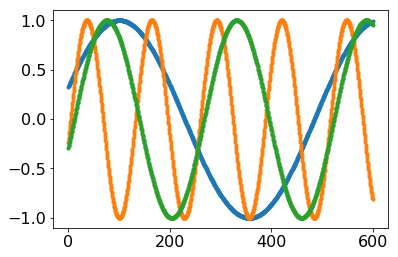

In [32]:
# start off with simplest case for proof of concept
n_timesteps = 1201

sig1_coeffs = {'phase_range': (0, 2 * np.pi), 'amplitude': 1.0, 'period': 512.0, 'offset': 0.0}
sig2_coeffs = {'phase_range': (0, 2 * np.pi), 'amplitude': 1.0, 'period': 128.0, 'offset': 0.0}
sig3_coeffs = {'phase_range': (0, 2 * np.pi), 'amplitude': 1.0, 'period': 256.0, 'offset': 0.0}
coeffs_list = [sig1_coeffs, sig2_coeffs, sig3_coeffs]

msig = MixedSignal(0, 600, n_timesteps, coeffs_list)
n_signals = len(msig)
X, y = msig()

print(X.shape, y.shape)
# print(X)
# print(y)

for i in range(n_signals):
    plt.plot(msig.timestamps, msig.signals[i], marker='.')

In [7]:
def highlight_column_matches(data, column='', color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_mixed = data == data[column]
        return [attr if v else '' for v in is_mixed]
    else:  # from .apply(axis=None)
        is_mixed = data == data[column]
        return pd.DataFrame(np.where(is_mixed, attr, ''), index=data.index, columns=data.columns)
    
df = pd.DataFrame(np.vstack((msig.signals, msig.mixed_signal)).T, index=msig.timestamps, columns=['A', 'B', 'C', 'Mixed'])
df[:5].style.apply(highlight_column_matches, column='Mixed', color='lightblue', axis=1)

,A,B,C,Mixed
0.0,2.11831,-0.484364,-3.55532,2.11831
0.5,2.10334,-0.540546,-3.59546,-3.59546
1.0,2.08934,-0.594413,-3.63416,2.08934
1.5,2.07631,-0.645735,-3.67134,-0.645735
2.0,2.06427,-0.694291,-3.7069,-3.7069
2.5,2.05323,-0.739875,-3.74075,2.05323
3.0,2.0432,-0.782291,-3.77282,-3.77282
3.5,2.0342,-0.821356,-3.80303,-3.80303
4.0,2.02623,-0.856905,-3.8313,2.02623
4.5,2.01931,-0.888784,-3.85758,-0.888784


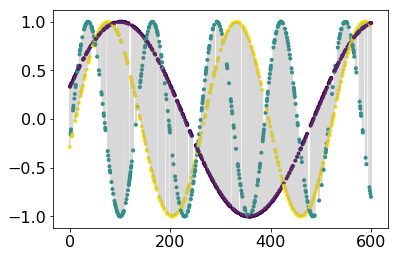

In [33]:
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.labels)

In [39]:
# define model
model = Sequential()
# model.add(Masking(mask_value=-1, input_shape=(1,)))
# model.add(LSTM(5))
# model.add(LSTM(5, input_shape=(2, 1)))
model.add(LSTM(16, return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(16))
# model.add(LSTM(5, input_shape=(n_timesteps, 2)))
model.add(Dense(n_signals, activation='softmax'))


# model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))
# model.add(LSTM(32, return_sequences=True))
# model.add(LSTM(32))

# model.add(LSTM(2048, return_sequences=False, input_shape=self.input_shape, dropout=0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

for i in range(200):
#     X, y = msig.generate_batch(64)
    X, y = msig.generate()
    model.fit(X, y, epochs=1, batch_size=1, verbose=1, shuffle=False)
#     model.reset_states()
#     model.fit(X, y, epochs=1, batch_size=1, verbose=2)

x_test, y_test = msig.generate()
score = model.evaluate(x_test, y_test, batch_size=1)
print(score)

Epoch 1/1
1201/1201 [==============================] - 15s 12ms/step - loss: 1.0948 - acc: 0.3780
Epoch 1/1
1201/1201 [==============================] - 15s 12ms/step - loss: 1.1055 - acc: 0.3047
Epoch 1/1
1201/1201 [==============================] - 15s 12ms/step - loss: 1.0932 - acc: 0.3547
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0917 - acc: 0.3605
Epoch 1/1
1201/1201 [==============================] - 15s 12ms/step - loss: 1.1044 - acc: 0.3297
Epoch 1/1
1201/1201 [==============================] - 15s 12ms/step - loss: 1.0982 - acc: 0.3714
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0955 - acc: 0.3597
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0805 - acc: 0.3972
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0845 - acc: 0.3597
Epoch 1/1
1201/1201 [==============================] - 15s 13ms/step - loss: 1.0856 - acc: 0.3705
Epoch 1/1
1201/1201 

1201/1201 [==============================] - 14s 12ms/step - loss: 1.0662 - acc: 0.4230
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0045 - acc: 0.4563
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0199 - acc: 0.4963
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0108 - acc: 0.4771
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9639 - acc: 0.5162
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0459 - acc: 0.4313
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9812 - acc: 0.5204
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9104 - acc: 0.5329
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9648 - acc: 0.4988
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9432 - acc: 0.5104
Epoch 1/1
1201/1201 [=========

1201/1201 [==============================] - 14s 12ms/step - loss: 0.9972 - acc: 0.5271
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9665 - acc: 0.5162
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9284 - acc: 0.5021
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.8852 - acc: 0.5279
Epoch 1/1
1201/1201 [==============================] - 14s 11ms/step - loss: 1.0232 - acc: 0.4538
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9183 - acc: 0.5379
Epoch 1/1
1201/1201 [==============================] - 15s 13ms/step - loss: 0.9134 - acc: 0.5329
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9280 - acc: 0.5346
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 0.9516 - acc: 0.5054
Epoch 1/1
1201/1201 [==============================] - 14s 12ms/step - loss: 1.0306 - acc: 0.4838
Epoch 1/1
1201/1201 [=========

In [ ]:
y_hat = model.predict(x_test)
for i in range(len(x_test)):
    print('Expected', y_test[i], 'Predicted', y_hat[i])

(1201, 1, 1)
(1201, 3)
(1201,)
(1201,)


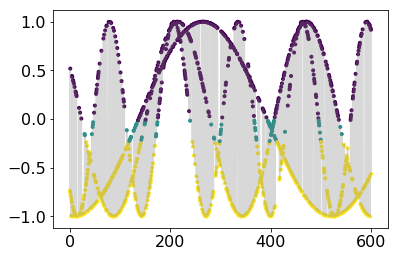

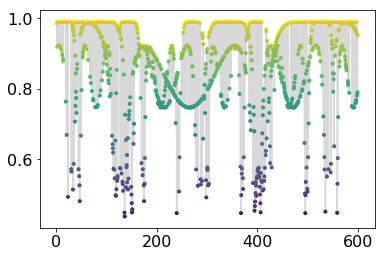

In [40]:
x_test, y_test = msig.generate()
print(x_test.shape)
y_hat = model.predict(x_test)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = np.max(y_hat, axis=1)
# y_error = msig.labels - y_hat
print(y_error.shape)
plt.plot(msig.timestamps, x_test[:, 0, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps, x_test[:, 0, 0], marker='.', c=y_pred)
plt.show()

plt.plot(msig.timestamps, y_error, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, y_error, marker='.', c=y_error)
plt.show()